# Graph Convloutional Networks for molecular property prediction
Written by W.-H. Shin @KUCM\
Aug. 2. 2025\
Modified from GNN for chemists.


## Setup

In [1]:
#@title Install required libraries
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
!pip install -q rdkit
!pip install -q networkx
!pip install -q jupyter-black
%load_ext jupyter_black

2.6.0+cu124
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 57.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 30.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.3/36.3 MB 62.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 46.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 75.0 MB/s eta 0:00:00


In [2]:
# @title import libraries
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns

import numpy as np
import pandas as pd

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch_geometric.loader import DataLoader
from torch_geometric.datasets import MoleculeNet
from torch_geometric.nn import GCNConv, global_mean_pool, global_add_pool

## 1. Introduction

This notebook provides an  explanation and implementation of Graph Convolutional Networks (GCNs), with a specific focus on their application to molecular property prediction. We'll start with the theoretical foundations, implement a GCN from scratch, and then use PyTorch Geometric to predict molecular properties such as binding affinity.

### Learning Objectives
- Understand the theory behind Graph Convolutional Networks (GCNs)
- Visualize how GCNs process graph-structured data in the context of molecules
- Implement a GCN from scratch using PyTorch
- Apply a GCN model to predict molecular properties using PyTorch Geometric
- Evaluate and visualize the results of molecular property prediction

## 2. Theoretical Background: Graph Convolutional Networks <a name="theoretical-background-graph-convolutions-network"> </a>

### 2.1 Graph Representation and Notation

In the context of molecules, graphs provide a natural representation where:
- Atoms are represented as nodes
- Chemical bonds are represented as edges

Mathematically, we define a graph $G = (V, E)$ where:
- $V$ is the set of nodes (atoms)
- $E$ is the set of edges (chemical bonds)

Each node $i$ has a feature vector $\mathbf{x}_i$ that could represent properties like:
- Atom type (C, N, O, etc.)
- Formal charge
- Hybridization state
- Etc.

The graph structure can be represented as an adjacency matrix $\mathbf{A}$, where:
- $\mathbf{A}_{ij} = 1$ if there is an edge between nodes $i$ and $j$
- $\mathbf{A}_{ij} = 0$ otherwise

Think of the adjacency matrix as a "connectivity map" showing which atoms are connected to each other. This representation allows us to work with molecular structures in a mathematical framework.


Let's visualize these concepts using aspirin as an example:

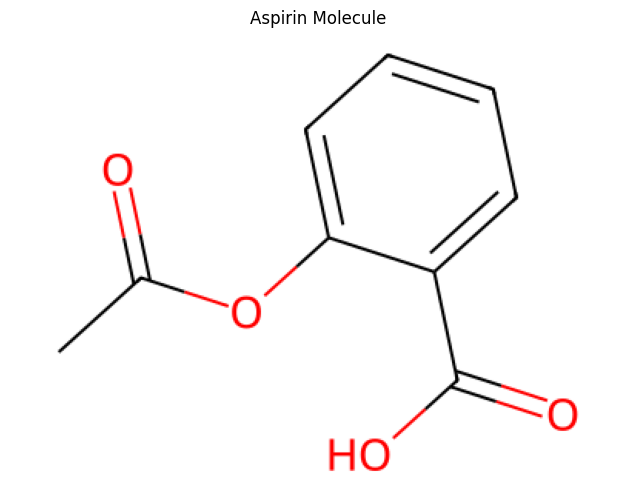

In [3]:
# @title 2D structure of aspirin
# Define a simple molecule (aspirin)
aspirin_smiles = "CC(=O)OC1=CC=CC=C1C(=O)O"
mol = Chem.MolFromSmiles(aspirin_smiles)
AllChem.Compute2DCoords(mol)
# Note: We could add hydrogen explicitly with Chem.AddHs(mol) if needed for the analysis

# Visualize the molecule using RDKit
mol_img = Draw.MolToImage(mol, size=(400, 300))
plt.figure(figsize=(10, 6))
plt.imshow(mol_img)
plt.axis("off")
plt.title("Aspirin Molecule")
plt.show()

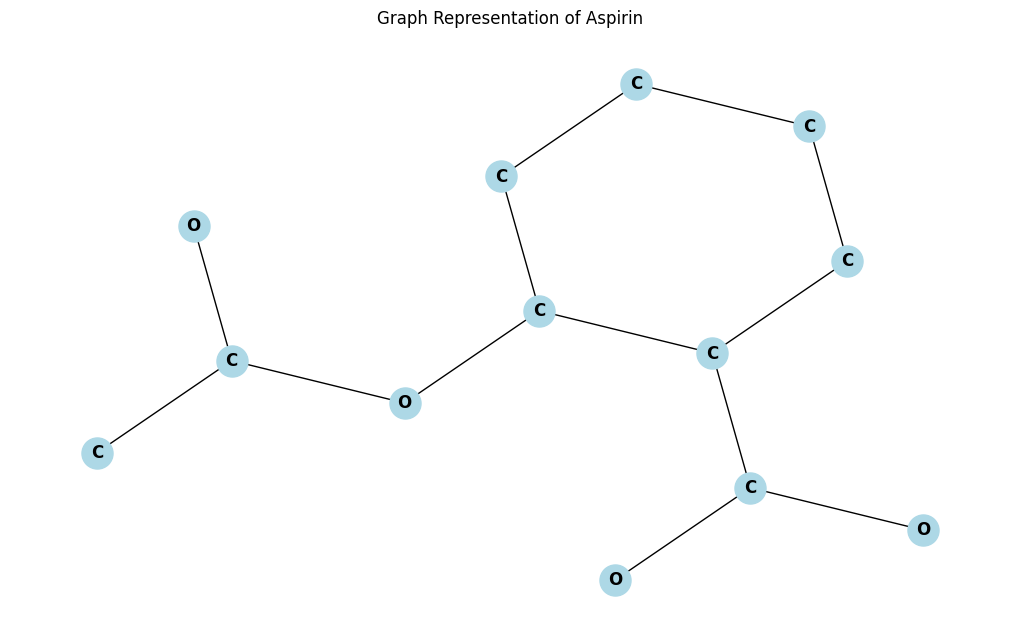

In [4]:
# @title Graph representation of the molecule
# Create a NetworkX graph from the molecule to visualize its graph structure
G = nx.Graph()

# Add nodes (atoms) to the graph
atom_symbols = []
for atom in mol.GetAtoms():
    G.add_node(atom.GetIdx(), symbol=atom.GetSymbol())
    atom_symbols.append(atom.GetSymbol())

# Add edges (bonds) to the graph
for bond in mol.GetBonds():
    G.add_edge(bond.GetBeginAtomIdx(), bond.GetEndAtomIdx())

# Create a visualization of the graph structure
plt.figure(figsize=(10, 6))
# Get the 2D coordinates from RDKit
pos = {}
for i, atom in enumerate(mol.GetAtoms()):
    pos[i] = mol.GetConformer().GetAtomPosition(i)
    pos[i] = (pos[i].x, pos[i].y)
nx.draw(
    G,
    pos,
    with_labels=True,
    labels={i: atom_symbols[i] for i in range(len(atom_symbols))},
    node_color="lightblue",
    node_size=500,
    font_weight="bold",
)
plt.title("Graph Representation of Aspirin")
plt.show()

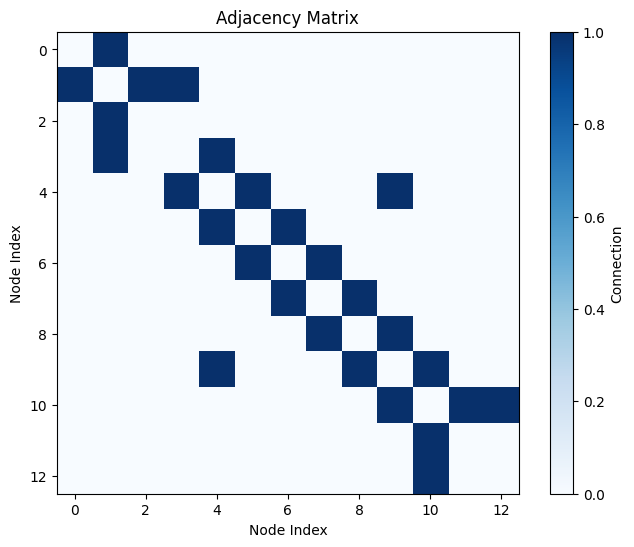

In [5]:
# @title Adjacency matrix
# Generate adjacency matrix - the mathematical representation of the graph
A = nx.adjacency_matrix(G).toarray()

# Visualize the adjacency matrix
plt.figure(figsize=(8, 6))
plt.imshow(A, cmap="Blues")
plt.colorbar(label="Connection")
plt.title("Adjacency Matrix")
plt.xlabel("Node Index")
plt.ylabel("Node Index")
plt.show()

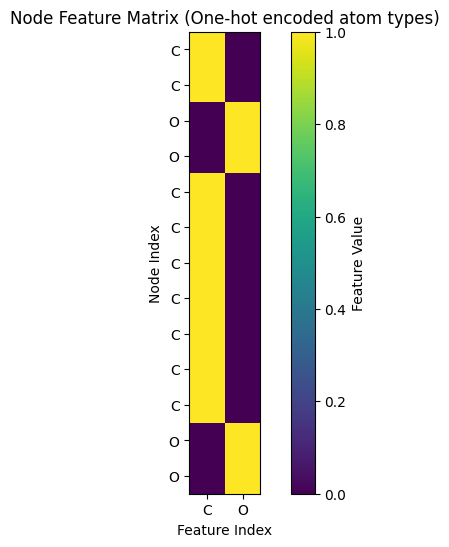

In [6]:
# @title One-hot encoding
# Example node features (one-hot encoding of atom types)
# One-hot encoding means each atom type gets its own dimension in the feature vector
unique_atoms = sorted(set(atom_symbols))
atom_to_idx = {atom: i for i, atom in enumerate(unique_atoms)}
n_atoms = len(atom_symbols)
n_features = len(unique_atoms)

# Create the feature matrix (each row represents an atom, each column an atom type)
X = np.zeros((n_atoms, n_features))
for i, atom in enumerate(atom_symbols):
    X[i, atom_to_idx[atom]] = 1

# Visualize the node feature matrix
plt.figure(figsize=(8, 6))
plt.imshow(X, cmap="viridis")
plt.colorbar(label="Feature Value")
plt.title("Node Feature Matrix (One-hot encoded atom types)")
plt.xlabel("Feature Index")
plt.ylabel("Node Index")
plt.yticks(range(n_atoms), atom_symbols)
plt.xticks(range(n_features), unique_atoms)
plt.show()

### 2.2 Graph Prediction Tasks
Before diving deeper into GCNs, let's understand what kinds of problems we can solve with graph-based machine learning.

Graph-based problems typically fall into three main categories:

1. **Node Classification**: Predicting properties of individual nodes
    - *Chemistry example*: Predicting the reactivity of specific atoms in a molecule

2. **Link Prediction / Edge Classification**: Predicting connections between nodes
    - *Chemistry example*: Predicting if a chemical bond might form between two atoms

3. **Graph Classification**: Predicting properties of entire graphs
    - *Chemistry example*: Predicting if a molecule will be active against a biological target

In this tutorial, we'll focus primarily on graph classification, as we want to predict properties of entire molecules.

<image src="https://storage.googleapis.com/dm-educational/assets/graph-nets/graph_tasks.png" width="700px">

### 2.3 The Graph Convolutional Network Model (Kipf & Welling, 2017)

The key insight of GCNs is to perform convolution operations directly on graphs by aggregating neighboring node features. This allows for learning representations that respect the graph structure.

In the seminal paper by Thomas Kipf and Max Welling (2017), the layer-wise propagation rule for GCNs is defined as:

$$H^{(l+1)} = \sigma(\tilde{D}^{-\frac{1}{2}}\tilde{A}\tilde{D}^{-\frac{1}{2}}H^{(l)}W^{(l)})$$

Where:
- $H^{(l)}$ is the matrix of node features at layer $l$ (with $H^{(0)} = X$)
- $\tilde{A} = A + I$ is the adjacency matrix with self-connections (identity matrix $I$)
- $\tilde{D}$ is the degree matrix of $\tilde{A}$
- $W^{(l)}$ is the weight matrix for layer $l$
- $\sigma$ is a non-linear activation function (e.g., ReLU)

The GCN operation can be broken down into two main steps:

1. **Compute messages / update node features**: Create a feature vector $\vec{h}_n$ for each node $n$ (using a neural network). This becomes the message that the node will pass to its neighbors.

2. **Message-passing / aggregate node features**: For each node, calculate a new feature vector $\vec{h}'_n$ based on the messages from its neighborhood. This is how information flows through the molecular graph.

The diagram below illustrates this aggregation step:

<image src="https://storage.googleapis.com/dm-educational/assets/graph-nets/graph_conv.png" width="500px">

*\"A generic overview of a graph convolution operation, highlighting the relevant information for deriving the next-level features for every node in the graph.\"* Image source: Petar Veličković (https://github.com/PetarV-/TikZ)


Let's visualize how this works with a simple graph:

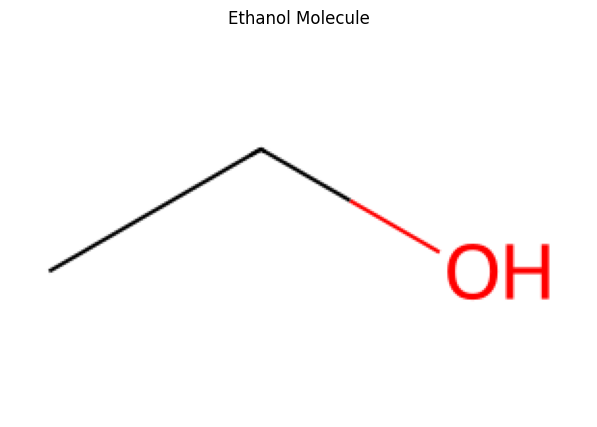

In [7]:
# @title A simpler example: ethanol
# Create a simpler example for illustration
simple_mol_smiles = "CCO"  # Ethanol - a simple molecule with just 3 atoms
simple_mol = Chem.MolFromSmiles(simple_mol_smiles)

# Visualize the molecule
simple_mol_img = Draw.MolToImage(simple_mol, size=(300, 200))
plt.figure(figsize=(8, 5))
plt.imshow(simple_mol_img)
plt.axis("off")
plt.title("Ethanol Molecule")
plt.show()

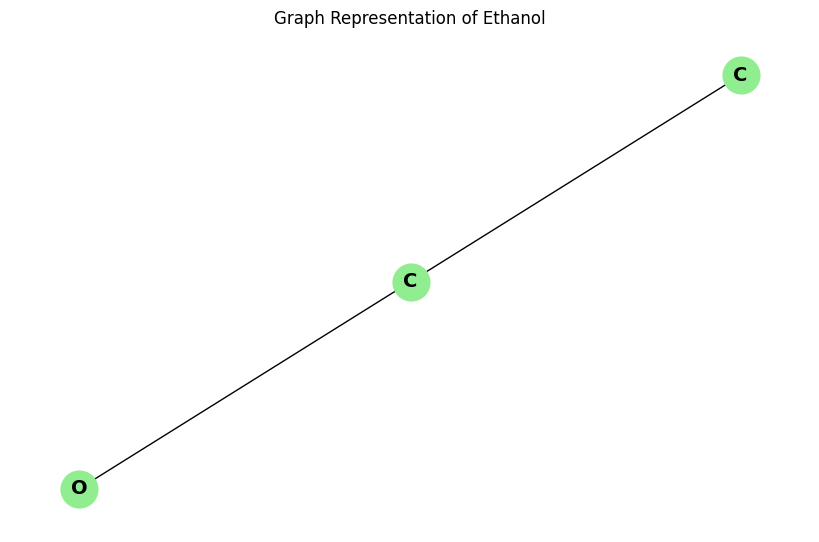

In [8]:
# @title Generate graph from the molecule
# Create a graph from the molecule
G_simple = nx.Graph()

# Add nodes (atoms)
atom_symbols_simple = []
for atom in simple_mol.GetAtoms():
    G_simple.add_node(atom.GetIdx(), symbol=atom.GetSymbol())
    atom_symbols_simple.append(atom.GetSymbol())

# Add edges (bonds)
for bond in simple_mol.GetBonds():
    G_simple.add_edge(bond.GetBeginAtomIdx(), bond.GetEndAtomIdx())

# Visualize the graph
plt.figure(figsize=(8, 5))
pos_simple = nx.spring_layout(G_simple, seed=42)
nx.draw(
    G_simple,
    pos_simple,
    with_labels=True,
    labels={i: atom_symbols_simple[i] for i in range(len(atom_symbols_simple))},
    node_color="lightgreen",
    node_size=700,
    font_weight="bold",
    font_size=14,
)
plt.title("Graph Representation of Ethanol")
plt.show()

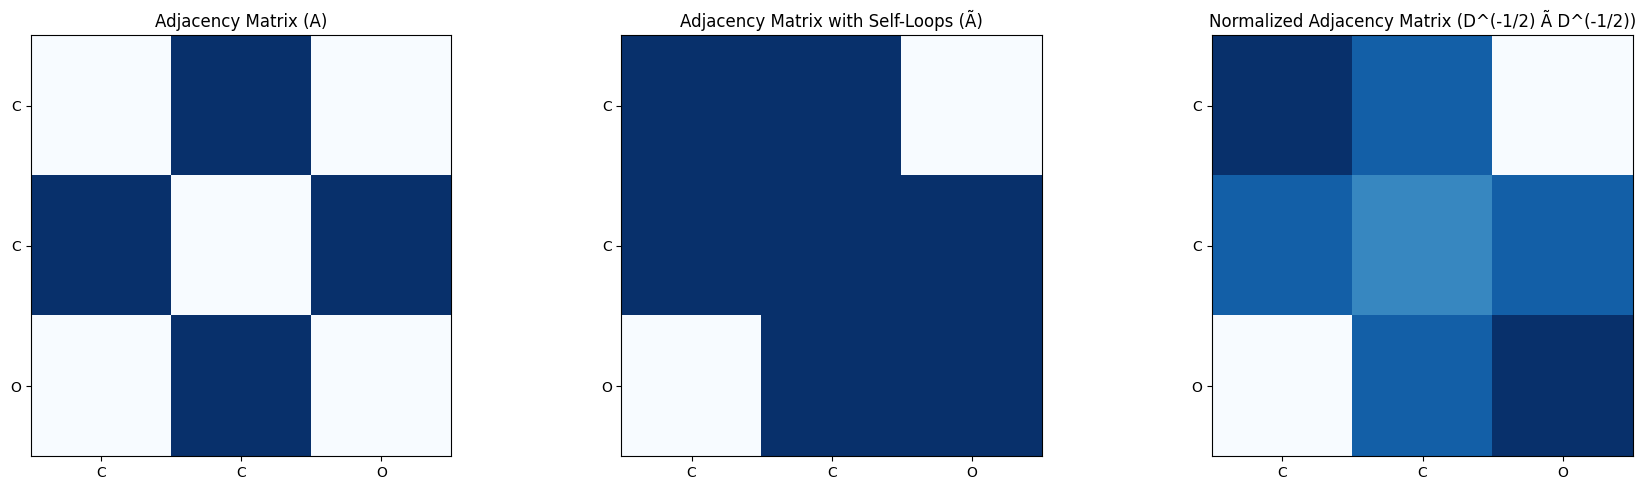

In [9]:
# @title Display adjacency matrix
# Get adjacency matrix
A_simple = nx.adjacency_matrix(G_simple).toarray()

# Calculate the normalized adjacency matrix as used in GCN
# Step 1: Add self-loops to the adjacency matrix (atoms can pass messages to themselves)
A_tilde = A_simple + np.eye(A_simple.shape[0])  # Add self-loops

# Step 2: Calculate the degree matrix (diagonal matrix with number of connections per node)
D_tilde = np.diag(np.sum(A_tilde, axis=1))  # Degree matrix

# Step 3: Calculate the inverse square root of the degree matrix
D_tilde_inv_sqrt = np.diag(1 / np.sqrt(np.sum(A_tilde, axis=1)))  # D^(-1/2)

# Step 4: Calculate the normalized adjacency matrix used in GCN
# This normalization ensures the scale of features doesn't explode during message passing
normalized_A = D_tilde_inv_sqrt @ A_tilde @ D_tilde_inv_sqrt  # D^(-1/2) A D^(-1/2)

# Visualize the matrices to understand the transformation
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].imshow(A_simple, cmap="Blues")
axes[0].set_title("Adjacency Matrix (A)")
axes[0].set_xticks(range(len(atom_symbols_simple)))
axes[0].set_yticks(range(len(atom_symbols_simple)))
axes[0].set_xticklabels(atom_symbols_simple)
axes[0].set_yticklabels(atom_symbols_simple)

axes[1].imshow(A_tilde, cmap="Blues")
axes[1].set_title("Adjacency Matrix with Self-Loops (Ã)")
axes[1].set_xticks(range(len(atom_symbols_simple)))
axes[1].set_yticks(range(len(atom_symbols_simple)))
axes[1].set_xticklabels(atom_symbols_simple)
axes[1].set_yticklabels(atom_symbols_simple)

axes[2].imshow(normalized_A, cmap="Blues")
axes[2].set_title("Normalized Adjacency Matrix (D^(-1/2) Ã D^(-1/2))")
axes[2].set_xticks(range(len(atom_symbols_simple)))
axes[2].set_yticks(range(len(atom_symbols_simple)))
axes[2].set_xticklabels(atom_symbols_simple)
axes[2].set_yticklabels(atom_symbols_simple)

plt.tight_layout()
plt.show()

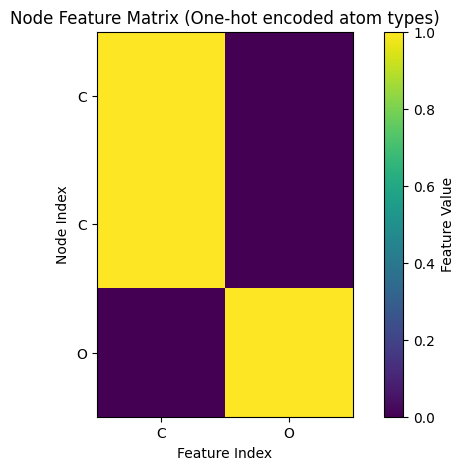

In [10]:
# @title One-hot encoding
# Create one-hot features for this simple molecule
# Each atom type (C, O) gets its own dimension in the feature vector
unique_atoms_simple = sorted(set(atom_symbols_simple))
atom_to_idx_simple = {atom: i for i, atom in enumerate(unique_atoms_simple)}
n_atoms_simple = len(atom_symbols_simple)
n_features_simple = len(unique_atoms_simple)

X_simple = np.zeros((n_atoms_simple, n_features_simple))
for i, atom in enumerate(atom_symbols_simple):
    X_simple[i, atom_to_idx_simple[atom]] = 1

# Visualize the feature matrix
plt.figure(figsize=(8, 5))
plt.imshow(X_simple, cmap="viridis")
plt.colorbar(label="Feature Value")
plt.title("Node Feature Matrix (One-hot encoded atom types)")
plt.xlabel("Feature Index")
plt.ylabel("Node Index")
plt.yticks(range(n_atoms_simple), atom_symbols_simple)
plt.xticks(range(n_features_simple), unique_atoms_simple)
plt.show()

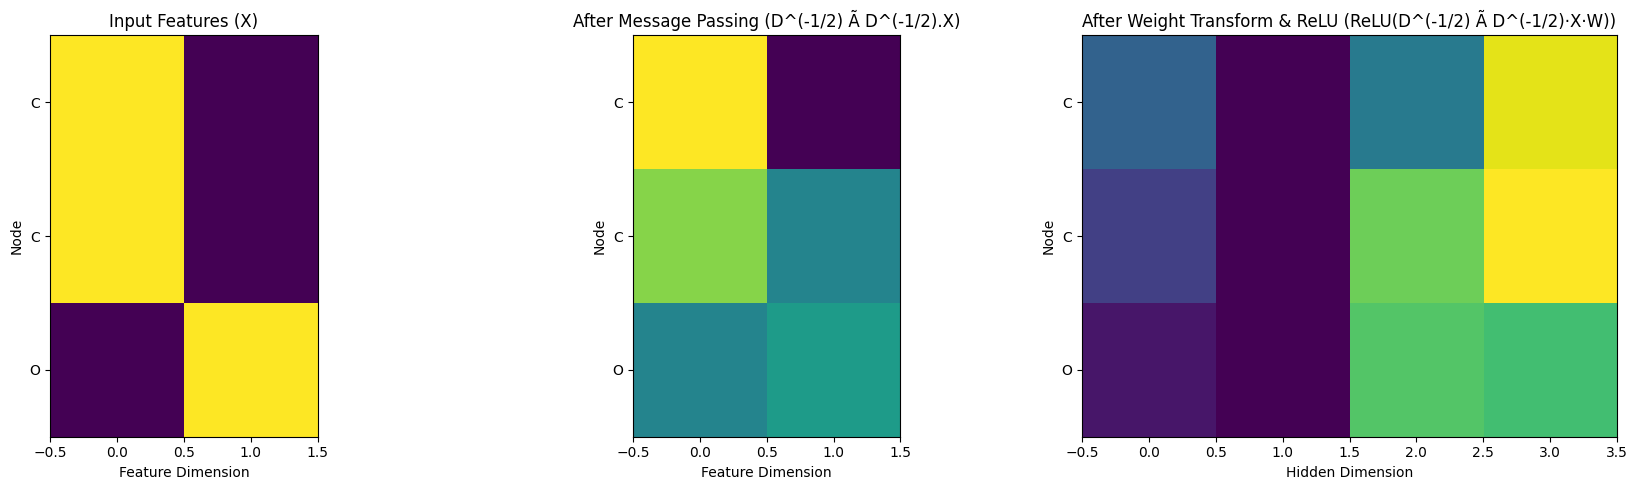

In [11]:
# @title Simultate GCN
# Simulate a GCN layer with random weights
np.random.seed(42)
hidden_dim = 4
W = np.random.randn(n_features_simple, hidden_dim)

# Simulating GCN forward pass:
# Step 1: Apply the normalized adjacency matrix to aggregate neighborhood information
# Step 2: Apply the weight matrix to transform features
# Step 3: Apply ReLU activation function
H = normalized_A @ X_simple @ W
H_activated = np.maximum(0, H)  # ReLU activation

# Visualize the transformation
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Original features
axes[0].imshow(X_simple, cmap="viridis")
axes[0].set_title("Input Features (X)")
axes[0].set_xlabel("Feature Dimension")
axes[0].set_ylabel("Node")
axes[0].set_yticks(range(n_atoms_simple))
axes[0].set_yticklabels(atom_symbols_simple)

# After message passing (before weight transformation)
axes[1].imshow(normalized_A @ X_simple, cmap="viridis")
axes[1].set_title("After Message Passing (D^(-1/2) Ã D^(-1/2).X)")
axes[1].set_xlabel("Feature Dimension")
axes[1].set_ylabel("Node")
axes[1].set_yticks(range(n_atoms_simple))
axes[1].set_yticklabels(atom_symbols_simple)

# After weight transformation and ReLU activation
axes[2].imshow(H_activated, cmap="viridis")
axes[2].set_title("After Weight Transform & ReLU (ReLU(D^(-1/2) Ã D^(-1/2)·X·W))")
axes[2].set_xlabel("Hidden Dimension")
axes[2].set_ylabel("Node")
axes[2].set_yticks(range(n_atoms_simple))
axes[2].set_yticklabels(atom_symbols_simple)

plt.tight_layout()
plt.show()

### 2.3 Understanding GCN Intuitively for Molecules

At the core, GCNs learn node representations by aggregating information from neighboring nodes. This is particularly well-suited for molecules because:

1. **Chemical Context**: Atoms' properties in molecules are highly influenced by their bonding environment
2. **Invariance**: The model respects the graph structure, ensuring prediction invariance to node ordering
3. **Message Passing**: Information flows along chemical bonds, mimicking how electronic effects propagate through molecules

Let's visualize the message passing process in a GCN to understand it more clearly:

In [12]:
# @title Coding a function for visualizing message passing
def visualize_message_passing(
    G: nx.Graph,
    pos: dict[int, tuple[float, float]],
    atom_labels: dict[int, str],
    features: np.ndarray,
    title: str,
) -> None:
    """Visualize the message passing mechanism.

    Args:
        G: NetworkX graph
        pos: Dictionary of node positions
        atom_labels: Dictionary of atom labels
        features: Array of node features
        title: Title of the plot
    """
    n_nodes = len(G.nodes())
    plt.figure(figsize=(12, 8))

    # Draw the graph structure
    nx.draw_networkx_edges(G, pos, alpha=0.5)
    nx.draw_networkx_labels(
        G, pos, labels=atom_labels, font_size=14, font_weight="bold"
    )

    # Create a color map from features
    node_colors = [
        "#1f77b4",
        "#ff7f0e",
        "#2ca02c",
    ]  # Different colors for different atom types

    # Draw nodes with their features as pie charts
    for i in range(n_nodes):
        feature = features[i]
        # Normalize features
        if np.sum(feature) > 0:
            feature = feature / np.sum(feature)

        # Draw a pie chart
        plt.pie(
            [feature[j] for j in range(len(feature))],
            colors=[node_colors[j] for j in range(len(feature))],
            center=(pos[i][0], pos[i][1]),
            radius=0.1,
            normalize=False,  # Since we already normalized manually
        )

    # Draw arrows to represent message passing
    for u, v in G.edges():
        # Calculate the midpoint of the edge
        mid_x = (pos[u][0] + pos[v][0]) / 2
        mid_y = (pos[u][1] + pos[v][1]) / 2

        # Calculate the vector from u to v
        dx = pos[v][0] - pos[u][0]
        dy = pos[v][1] - pos[u][1]

        # Normalize the vector
        length = np.sqrt(dx**2 + dy**2)
        if length == 0:  # Add check for zero division
            continue

        dx = dx / length
        dy = dy / length

        # Draw an arrow near the midpoint
        plt.arrow(
            mid_x - 0.15 * dx,
            mid_y - 0.15 * dy,
            0.1 * dx,
            0.1 * dy,
            head_width=0.05,
            head_length=0.05,
            fc="red",
            ec="red",
        )
        plt.arrow(
            mid_x + 0.05 * dx,
            mid_y + 0.05 * dy,
            -0.1 * dx,
            -0.1 * dy,
            head_width=0.05,
            head_length=0.05,
            fc="blue",
            ec="blue",
        )

    plt.axis("off")
    plt.title(title)
    plt.tight_layout()
    plt.show()

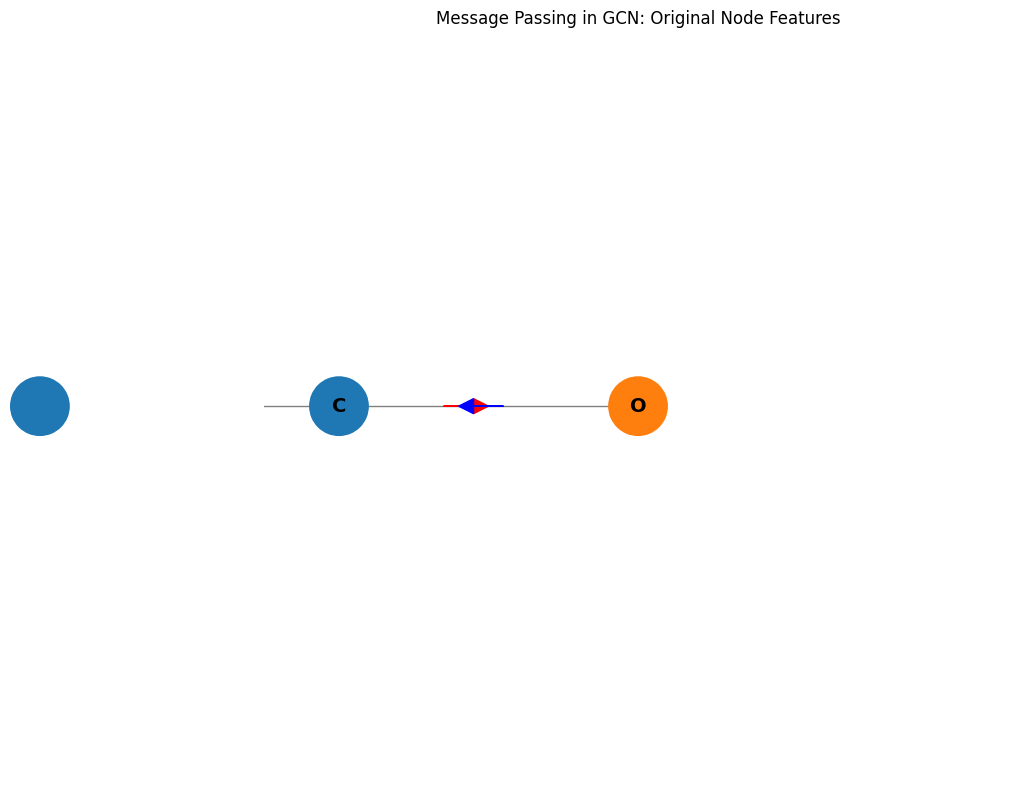

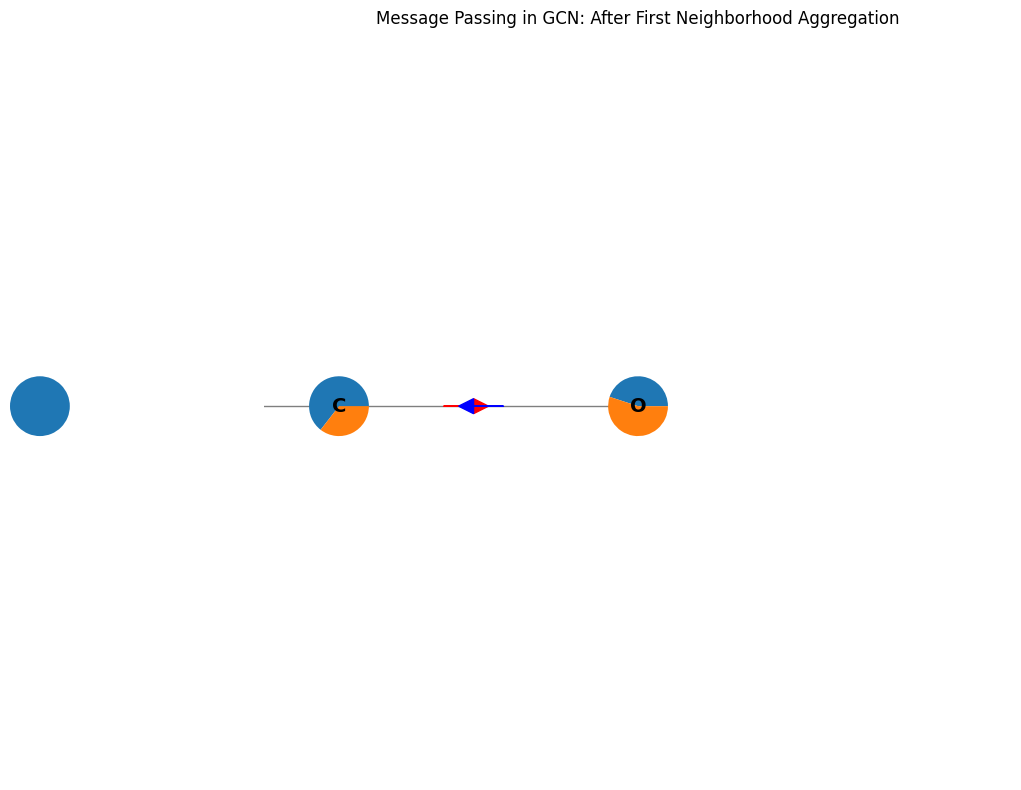

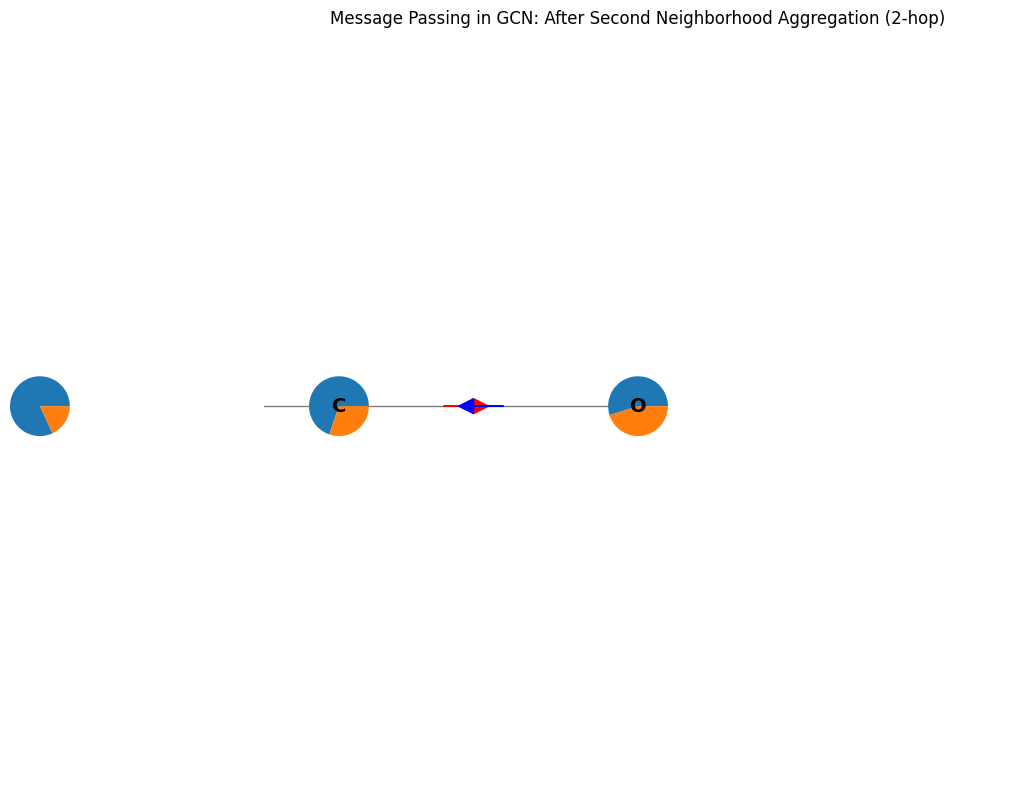

In [13]:
# @title Visualize it for ethanol
# Create a fixed position layout for our ethanol graph
pos_fixed = {0: (0, 0), 1: (1, 0), 2: (2, 0)}

# Visualize original features (before any message passing)
visualize_message_passing(
    G_simple,
    pos_fixed,
    {i: atom_symbols_simple[i] for i in range(len(atom_symbols_simple))},
    X_simple,
    "Message Passing in GCN: Original Node Features",
)

# Visualize after first message passing step
# Each atom now contains information from its direct neighbors
visualize_message_passing(
    G_simple,
    pos_fixed,
    {i: atom_symbols_simple[i] for i in range(len(atom_symbols_simple))},
    normalized_A @ X_simple,
    "Message Passing in GCN: After First Neighborhood Aggregation",
)

# Visualize after second message passing step
# Now each atom has information from atoms up to 2 bonds away
# This is how GCNs propagate information through the molecular structure
visualize_message_passing(
    G_simple,
    pos_fixed,
    {i: atom_symbols_simple[i] for i in range(len(atom_symbols_simple))},
    normalized_A @ (normalized_A @ X_simple),
    "Message Passing in GCN: After Second Neighborhood Aggregation (2-hop)",
)

### 2.4 Key Advantages of GCNs for Molecular Applications

1. **Respects Molecular Structure**: Graph-based approach naturally handles the connectivity of atoms
2. **Learns Both Local and Global Features**: Can capture both local chemical environments and overall molecular structure
3. **Invariant to Atom Ordering**: Same molecule will give same prediction regardless of how atoms are indexed
4. **Handles Variable-Sized Molecules**: Can process molecules with different numbers of atoms
5. **Interpretable**: Feature maps can often be related back to chemical substructures

In the next section, we'll implement a GCN from scratch to better understand its internal workings.

## 3. Implementing a GCN from Scratch

To deepen our understanding, let's implement a Graph Convolutional Network from scratch using PyTorch. This will help us understand exactly what happens in each layer of the network.


In [14]:
# @title A simple GCN
class GraphConvolution(nn.Module):
    """
    Simple GCN layer, similar to https://arxiv.org/abs/1609.02907
    """

    def __init__(self, in_features: int, out_features: int, bias: bool = True) -> None:
        """
        Initialize the GraphConvolution layer.

        Args:
            in_features (int): Number of input features per node
            out_features (int): Number of output features per node
            bias (bool, optional): If True, add a bias term. Default is True.
        """
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = nn.Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter("bias", None)
        self.reset_parameters()

    def reset_parameters(self) -> None:
        """
        Reset the parameters of the layer.
        """
        nn.init.kaiming_uniform_(self.weight)  # Initialize weights
        if self.bias is not None:
            nn.init.zeros_(self.bias)  # Initialize bias to zero

    def forward(self, input: torch.Tensor, adj: torch.Tensor) -> torch.Tensor:
        support = torch.mm(input, self.weight)  # Linear transformation
        output = torch.spmm(
            adj, support
        )  # Matrix multiplication with adjacency matrix (should be normalized adjacency matrix)
        if self.bias is not None:
            return output + self.bias  # Add bias if it exists
        else:
            return output

    def __repr__(self) -> str:
        return (
            self.__class__.__name__
            + " ("
            + str(self.in_features)
            + " -> "
            + str(self.out_features)
            + ")"
        )


class GCN(nn.Module):
    """
    Simple GCN model.
    """

    def __init__(self, nfeat: int, nhid: int, nout: int, dropout: float) -> None:
        """
        Initialize the GCN model.

        Args:
            nfeat (int): Number of input features per node
            nhid (int): Number of hidden features
            nout (int): Number of output features
            dropout (float): Dropout rate
        """
        super(GCN, self).__init__()
        self.gc1 = GraphConvolution(nfeat, nhid)  # First GCN layer
        self.gc2 = GraphConvolution(nhid, nout)  # Second GCN layer
        self.dropout = dropout  # Dropout rate

    def forward(self, x: torch.Tensor, adj: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the GCN model.

        Args:
            x (torch.Tensor): Input features
            adj (torch.Tensor): Adjacency matrix (should be normalized adjacency matrix)

        Returns:
            torch.Tensor: Output features
        """
        x = F.relu(self.gc1(x, adj))  # Apply first GCN layer
        x = F.dropout(x, self.dropout, training=self.training)  # Apply dropout
        x = self.gc2(x, adj)  # Apply second GCN layer
        return x

In [15]:
# @title Apply GCN on ethanol
# Convert numpy arrays to PyTorch tensors
adj_tensor = torch.FloatTensor(normalized_A)
features_tensor = torch.FloatTensor(X_simple)

# Initialize a GCN model
model = GCN(nfeat=n_features_simple, nhid=8, nout=2, dropout=0.5)
print(model)

# Forward pass
output = model(features_tensor, adj_tensor)
print("Output shape:", output.shape)
print("Output features:")
print(output)

GCN(
  (gc1): GraphConvolution (2 -> 8)
  (gc2): GraphConvolution (8 -> 2)
)
Output shape: torch.Size([3, 2])
Output features:
tensor([[-1.6956, -0.3415],
        [-1.5972, -1.0074],
        [-0.8726, -1.0243]], grad_fn=<AddBackward0>)


## 4. Visualizing the GCN Layer Operations in Detail

Let's break down the GCN operations step by step to understand what's happening inside:

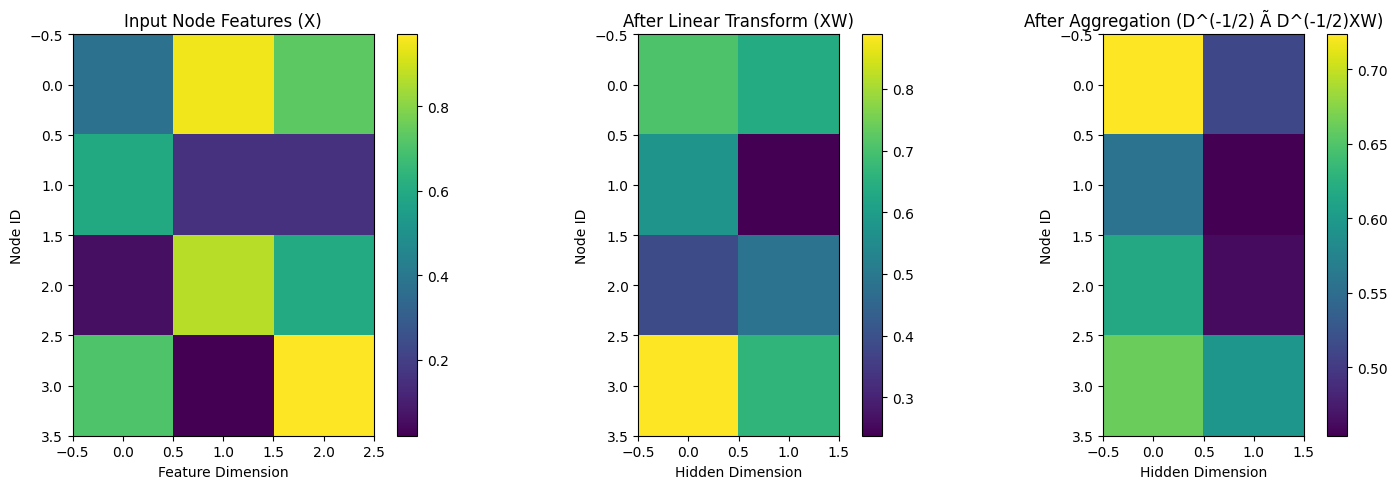

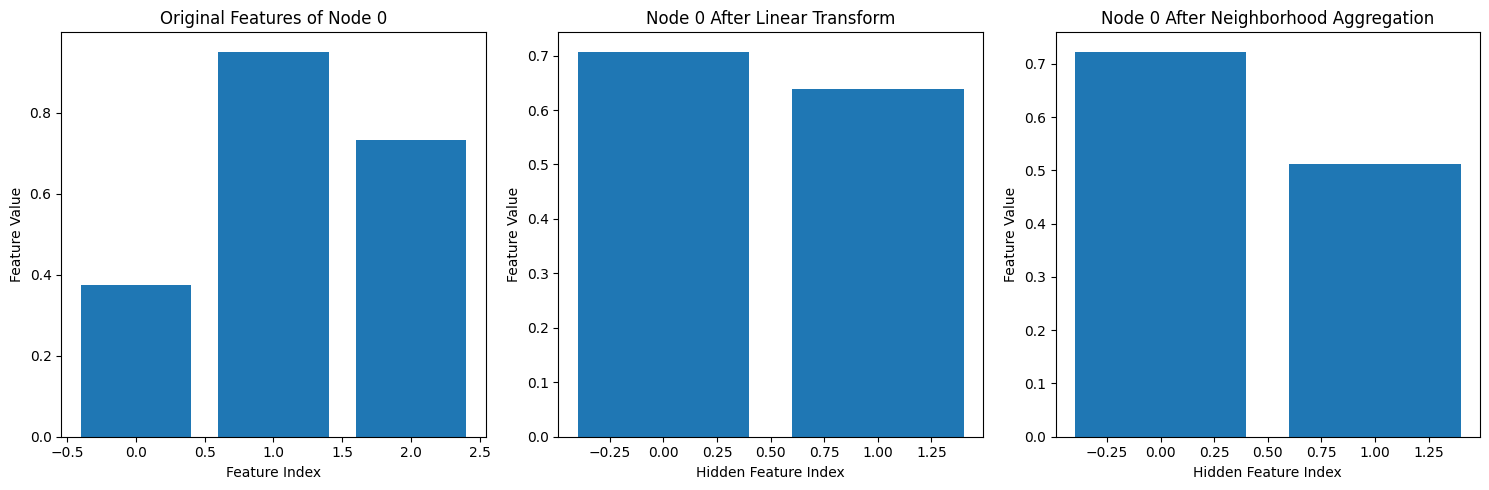

/tmp/ipython-input-1326448767.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


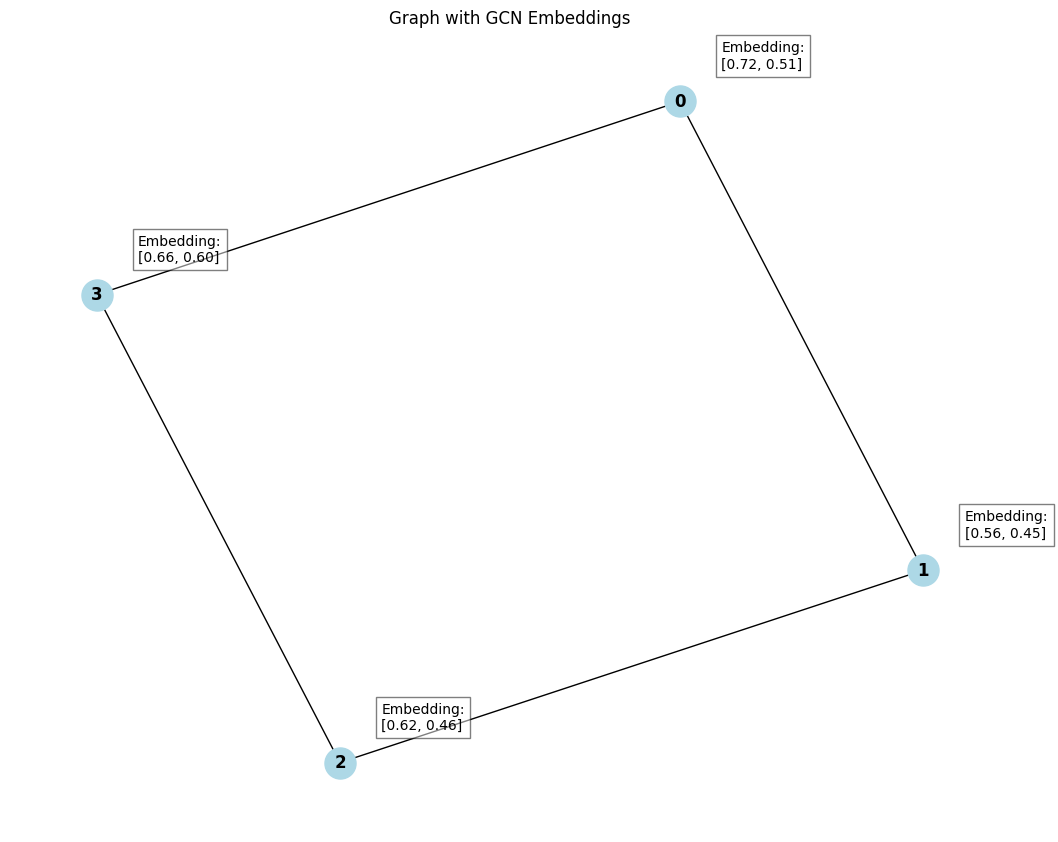

In [ ]:
# Let's use a simple artificial example
n_nodes = 4
n_features = 3

# Create a synthetic graph
G_demo = nx.cycle_graph(n_nodes)  # A cycle graph with 4 nodes
A_demo = nx.adjacency_matrix(G_demo).toarray()

# Add self-loops and normalize
A_tilde_demo = A_demo + np.eye(n_nodes)  # Add self-loops to the adjacency matrix
D_tilde_demo = np.diag(np.sum(A_tilde_demo, axis=1))  # Create degree matrix
D_tilde_inv_sqrt_demo = np.linalg.inv(
    np.sqrt(D_tilde_demo)
)  # Invert square root of degree matrix
normalized_A_demo = (
    D_tilde_inv_sqrt_demo @ A_tilde_demo @ D_tilde_inv_sqrt_demo
)  # Normalize adjacency matrix

# Create random feature matrix
np.random.seed(42)
X_demo = np.random.rand(n_nodes, n_features)

# Create random weight matrix
W_demo = np.random.rand(n_features, 2)  # Output dimension is 2

# Convert to PyTorch tensors
X_demo_tensor = torch.FloatTensor(X_demo)
A_demo_tensor = torch.FloatTensor(normalized_A_demo)
W_demo_tensor = torch.FloatTensor(W_demo)

# Step 1: Linear transformation of features
linear_transform = torch.mm(X_demo_tensor, W_demo_tensor)  # Linear transformation

# Step 2: Aggregation with normalized adjacency matrix
aggregated = torch.mm(A_demo_tensor, linear_transform)  # Aggregation

# Step 3: Apply non-linearity (ReLU)
activated = F.relu(aggregated)  # Apply ReLU activation

# Visualize each step
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(X_demo, cmap="viridis")
plt.title("Input Node Features (X)")
plt.xlabel("Feature Dimension")
plt.ylabel("Node ID")
plt.colorbar()

plt.subplot(1, 3, 2)
plt.imshow(linear_transform.numpy(), cmap="viridis")
plt.title("After Linear Transform (XW)")
plt.xlabel("Hidden Dimension")
plt.ylabel("Node ID")
plt.colorbar()

plt.subplot(1, 3, 3)
plt.imshow(aggregated.numpy(), cmap="viridis")
plt.title("After Aggregation (D^(-1/2) Ã D^(-1/2)XW)")
plt.xlabel("Hidden Dimension")
plt.ylabel("Node ID")
plt.colorbar()

plt.tight_layout()
plt.show()

# Alternative view: Following one node through the network
node_idx = 0  # Focus on first node
plt.figure(figsize=(15, 5))

# Original feature vector for this node
plt.subplot(1, 3, 1)
plt.bar(range(n_features), X_demo[node_idx])
plt.title(f"Original Features of Node {node_idx}")
plt.xlabel("Feature Index")
plt.ylabel("Feature Value")

# After linear transform
plt.subplot(1, 3, 2)
plt.bar(range(2), linear_transform[node_idx].numpy())
plt.title(f"Node {node_idx} After Linear Transform")
plt.xlabel("Hidden Feature Index")
plt.ylabel("Feature Value")

# After aggregation with neighbors
plt.subplot(1, 3, 3)
plt.bar(range(2), aggregated[node_idx].numpy())
plt.title(f"Node {node_idx} After Neighborhood Aggregation")
plt.xlabel("Hidden Feature Index")
plt.ylabel("Feature Value")

plt.tight_layout()
plt.show()

# Visualize the graph with it's embedding
plt.figure(figsize=(10, 8))

# Draw the graph structure
pos_demo = nx.spring_layout(G_demo, seed=42)
nx.draw(
    G_demo,
    pos_demo,
    node_color="lightblue",
    node_size=500,
    with_labels=True,
    font_weight="bold",
)

# Plot the 2D embedding beside each node
offset = 0.1
for i in range(n_nodes):
    plt.text(
        pos_demo[i][0] + offset,
        pos_demo[i][1] + offset,
        f"Embedding:\n[{aggregated[i, 0]:.2f}, {aggregated[i, 1]:.2f}]",
        fontsize=10,
        bbox=dict(facecolor="white", alpha=0.5),
    )

plt.title("Graph with GCN Embeddings")
plt.axis("off")
plt.tight_layout()
plt.show()

## 5. Building a Complete GCN for Molecular Property Prediction <a name="gcn-molecular-property-prediction"></a>

Now that we understand the GCN architecture, let's use PyTorch Geometric (PyG) to build a complete model for molecular property prediction. We'll use the ESOL dataset, a collection of data (1128 molecules), used for estimating the aqueous solubility of chemical compounds directly from their molecular structures:

In [16]:
# @title Data preparation
# Set random seed for reproducibility
torch.manual_seed(42)

# Download and process the ESOL dataset
dataset = MoleculeNet(root="data/", name="ESOL")

# Split the dataset
train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, random_state=42)
train_dataset, val_dataset = train_test_split(
    train_dataset, test_size=0.1, random_state=42
)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Check a sample from the dataset
sample = next(iter(train_loader))
print("Sample from ESOL dataset:")
print(f"Number of graphs in batch: {sample.num_graphs}")
print(f"Node features shape: {sample.x.shape}")
print(f"Edge index shape: {sample.edge_index.shape}")
print(f"Target shape: {sample.y.shape}")
print(f"Feature dimensions: {sample.num_features}")

Processing...


Sample from ESOL dataset:
Number of graphs in batch: 32
Node features shape: torch.Size([499, 9])
Edge index shape: torch.Size([2, 1058])
Target shape: torch.Size([32, 1])
Feature dimensions: 9


Done!


In [17]:
# @title Define our GCN model using PyTorch Geometric
class MolecularGCN(torch.nn.Module):
    """
    Molecular Graph Convolutional Network.
    """

    def __init__(
        self, node_features: int, hidden_channels: int, out_channels: int
    ) -> None:
        """
        Initialize the MolecularGCN model.

        Args:
            node_features (int): Number of input features per node
            hidden_channels (int): Number of hidden features
            out_channels (int): Number of output features
        """
        super(MolecularGCN, self).__init__()
        # GCN layers
        self.conv1 = GCNConv(node_features, hidden_channels)  # First GCN layer
        self.conv2 = GCNConv(hidden_channels, hidden_channels)  # Second GCN layer
        self.conv3 = GCNConv(hidden_channels, hidden_channels // 2)  # Third GCN layer

        # Readout layers
        self.lin1 = torch.nn.Linear(
            hidden_channels // 2, hidden_channels // 4
        )  # First readout layer
        self.lin2 = torch.nn.Linear(
            hidden_channels // 4, out_channels
        )  # Second readout layer

    def forward(
        self, x: torch.Tensor, edge_index: torch.Tensor, batch: torch.Tensor
    ) -> torch.Tensor:
        """
        Forward pass of the MolecularGCN model.

        Args:
            x (torch.Tensor): Input features
            edge_index (torch.Tensor): Edge index
            batch (torch.Tensor): Batch index

        Returns:
            torch.Tensor: Output features
        """
        # Node embeddings
        x = self.conv1(x, edge_index)  # First GCN layer
        x = F.relu(x)  # Apply ReLU activation
        x = F.dropout(x, p=0.2, training=self.training)  # Apply dropout

        x = self.conv2(x, edge_index)  # Second GCN layer
        x = F.relu(x)  # Apply ReLU activation
        x = F.dropout(x, p=0.2, training=self.training)  # Apply dropout

        x = self.conv3(x, edge_index)  # Third GCN layer
        x = F.relu(x)  # Apply ReLU activation

        # Global pooling (graph-level representation)
        x = global_mean_pool(x, batch)

        # Prediction head
        x = self.lin1(x)  # First readout layer
        x = F.relu(x)  # Apply ReLU activation
        x = F.dropout(x, p=0.2, training=self.training)  # Apply dropout

        x = self.lin2(x)  # Second readout layer

        return x

In [18]:
# @title Model initializing and setup functions
# Initialize the model
model = MolecularGCN(
    node_features=sample.num_features, hidden_channels=64, out_channels=1
)
print(model)

# Define loss function and optimizer
criterion = torch.nn.MSELoss()  # Mean Squared Error loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer


# Training function
def train() -> float:
    """
    Training loop for the MolecularGCN model.

    Returns:
        float: Average training loss
    """
    model.train()
    total_loss = 0
    for data in train_loader:
        optimizer.zero_grad()
        out = model(data.x.float(), data.edge_index, data.batch)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(train_loader.dataset)


# Validation function
def validate() -> float:
    """
    Validation loop for the MolecularGCN model.

    Returns:
        float: Average validation loss
    """
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for data in val_loader:
            out = model(data.x.float(), data.edge_index, data.batch)
            loss = criterion(out, data.y)
            total_loss += loss.item() * data.num_graphs
    return total_loss / len(val_loader.dataset)

MolecularGCN(
  (conv1): GCNConv(9, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 32)
  (lin1): Linear(in_features=32, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=1, bias=True)
)


Epoch: 005, Train Loss: 4.7691, Val Loss: 3.7797
Epoch: 010, Train Loss: 4.2466, Val Loss: 3.3811
Epoch: 015, Train Loss: 4.1946, Val Loss: 3.3244
Epoch: 020, Train Loss: 3.8396, Val Loss: 3.1277
Epoch: 025, Train Loss: 3.8591, Val Loss: 2.9002
Epoch: 030, Train Loss: 3.4291, Val Loss: 2.6473
Epoch: 035, Train Loss: 3.3904, Val Loss: 2.5930
Epoch: 040, Train Loss: 3.0305, Val Loss: 2.2182
Epoch: 045, Train Loss: 2.9463, Val Loss: 1.9969
Epoch: 050, Train Loss: 2.6247, Val Loss: 1.8236
Epoch: 055, Train Loss: 2.4850, Val Loss: 2.0004
Epoch: 060, Train Loss: 2.4053, Val Loss: 1.6239
Epoch: 065, Train Loss: 2.2661, Val Loss: 1.5300
Epoch: 070, Train Loss: 2.7255, Val Loss: 1.8409
Epoch: 075, Train Loss: 2.2181, Val Loss: 1.4813
Epoch: 080, Train Loss: 2.0191, Val Loss: 1.5533
Epoch: 085, Train Loss: 2.2130, Val Loss: 1.3482
Epoch: 090, Train Loss: 1.9961, Val Loss: 1.2687
Epoch: 095, Train Loss: 2.0509, Val Loss: 1.2608
Epoch: 100, Train Loss: 1.7956, Val Loss: 1.1399
Epoch: 105, Train Lo

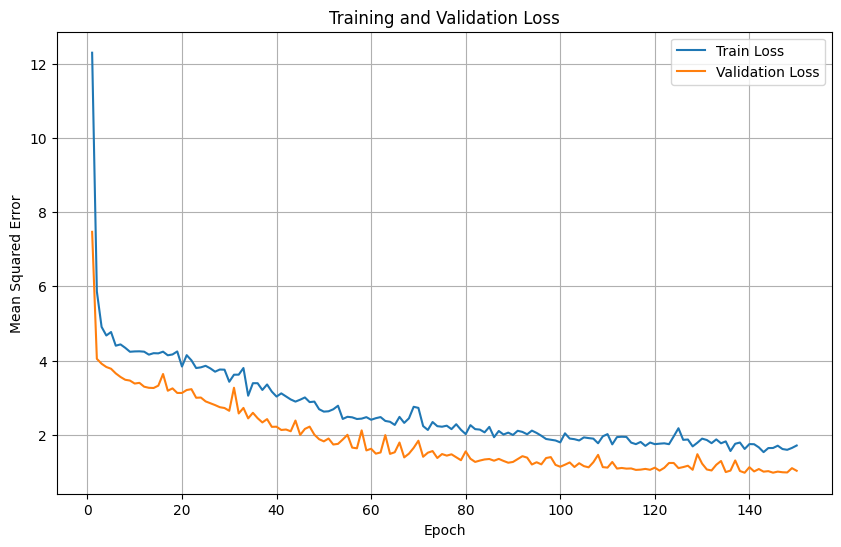

In [19]:
# @title Training
# Training loop
train_losses = []
val_losses = []
epochs = 150

for epoch in range(1, epochs + 1):
    train_loss = train()
    val_loss = validate()
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    if epoch % 5 == 0:
        print(
            f"Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}"
        )

# Plot training curves
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, epochs + 1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

Test MAE: 0.8806
Test R²: 0.7037


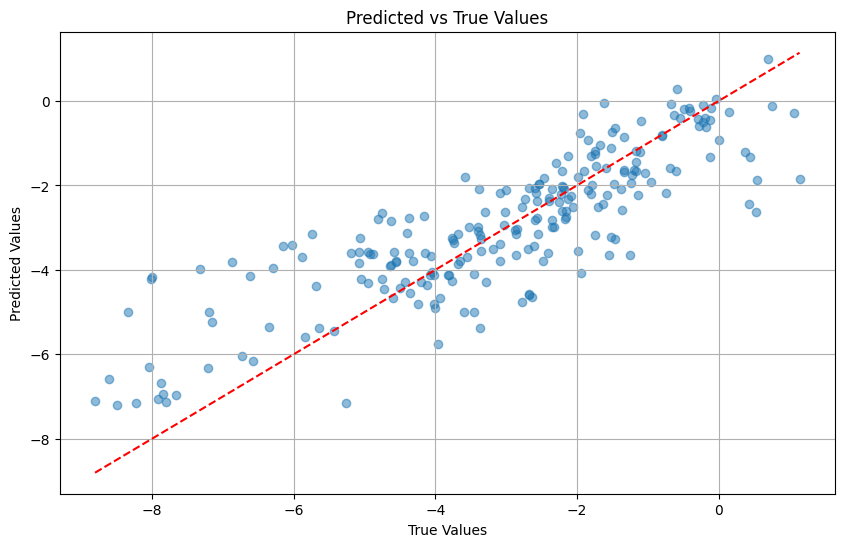

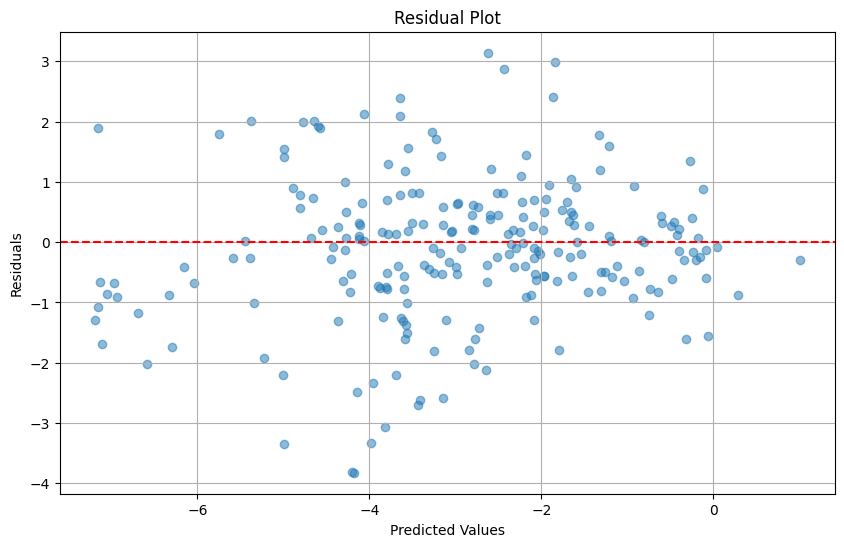

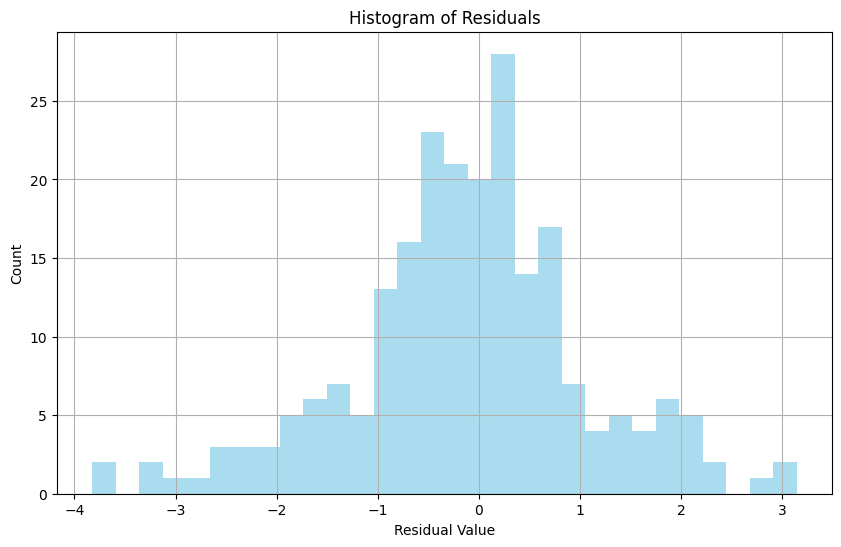

In [20]:
# @title Evaluate on test set
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for data in test_loader:
        out = model(data.x.float(), data.edge_index, data.batch)
        y_true.extend(data.y.view(-1).tolist())
        y_pred.extend(out.view(-1).tolist())

# Calculate metrics
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"Test MAE: {mae:.4f}")
print(f"Test R²: {r2:.4f}")

# Visualize predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_true, y_pred, alpha=0.5)
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], "r--")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs True Values")
plt.grid(True)
plt.show()

# Create a residual plot
residuals = np.array(y_true) - np.array(y_pred)
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color="r", linestyle="--")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.grid(True)
plt.show()

# Histogram of residuals
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, alpha=0.7, color="skyblue")
plt.xlabel("Residual Value")
plt.ylabel("Count")
plt.title("Histogram of Residuals")
plt.grid(True)
plt.show()

## 6. Visualizing Learned Molecular Representations <a name="visualize-learned-representation"></a>

One of the advantages of GCNs is that they learn meaningful representations of molecules. Let's visualize these learned representations:

In [21]:
# Get embeddings for test molecules
model.eval()
embeddings = []
targets = []
molecules = []


# Function to convert a molecule to its SMILES representation
def mol_to_smiles(data, index):
    # This is a simplified version - in practice you'd need to convert
    # from PyG format back to RDKit format
    return data[index].smiles


with torch.no_grad():
    for data in test_loader:
        # Get intermediate representations (after the last GCN layer, before pooling)
        x = model.conv1(data.x.float(), data.edge_index)
        x = F.relu(x)
        x = model.conv2(x, data.edge_index)
        x = F.relu(x)
        x = model.conv3(x, data.edge_index)
        x = F.relu(x)

        # Pooling to get molecule-level representation
        x_mol = global_mean_pool(x, data.batch)

        # Store embeddings and targets
        embeddings.extend(x_mol.cpu().numpy())
        targets.extend(data.y.view(-1).cpu().numpy())

        # For each molecule in the batch, extract SMILES
        batch_size = data.num_graphs
        for i in range(batch_size):
            # Get indices for this molecule
            mask = data.batch == i
            x_mol = data.x[mask]
            edge_index_mol = data.edge_index[:, mask[data.edge_index[0]]]
            # Convert to SMILES (simplified)
            smiles = mol_to_smiles(data, i)
            molecules.append(smiles)

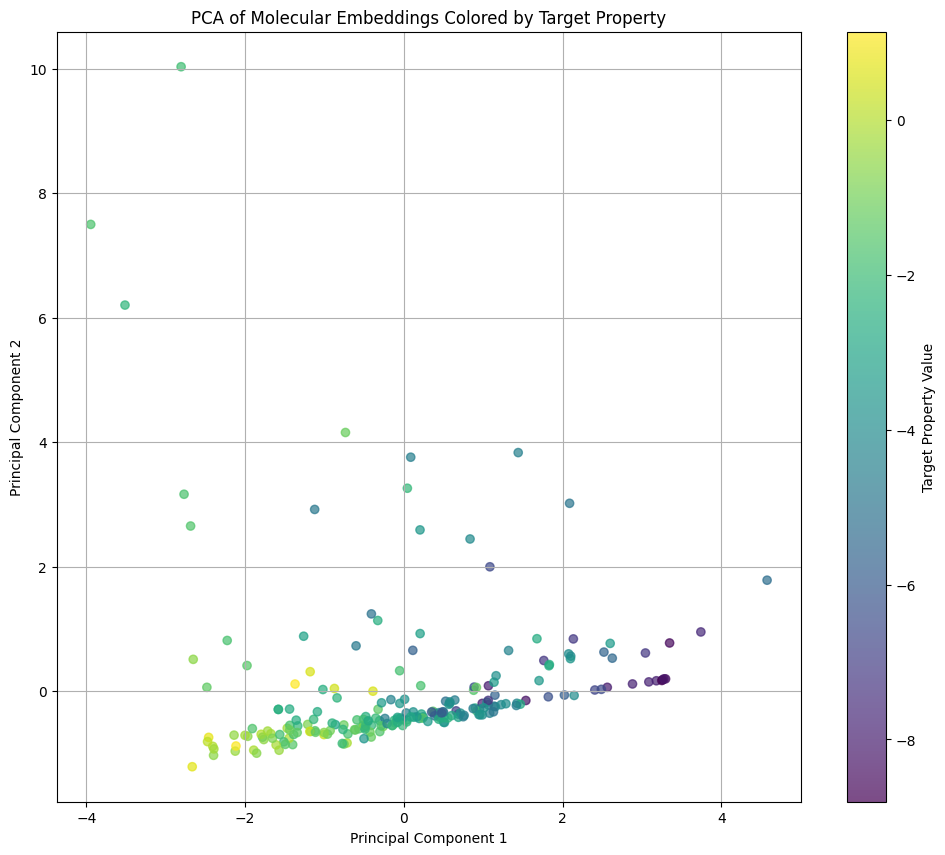

In [22]:
# @title PCA
# Convert to numpy arrays
embeddings = np.array(embeddings)
targets = np.array(targets)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

# Visualize with PCA
plt.figure(figsize=(12, 10))
scatter = plt.scatter(
    embeddings_2d[:, 0], embeddings_2d[:, 1], c=targets, cmap="viridis", alpha=0.7
)
plt.colorbar(scatter, label="Target Property Value")
plt.title("PCA of Molecular Embeddings Colored by Target Property")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()

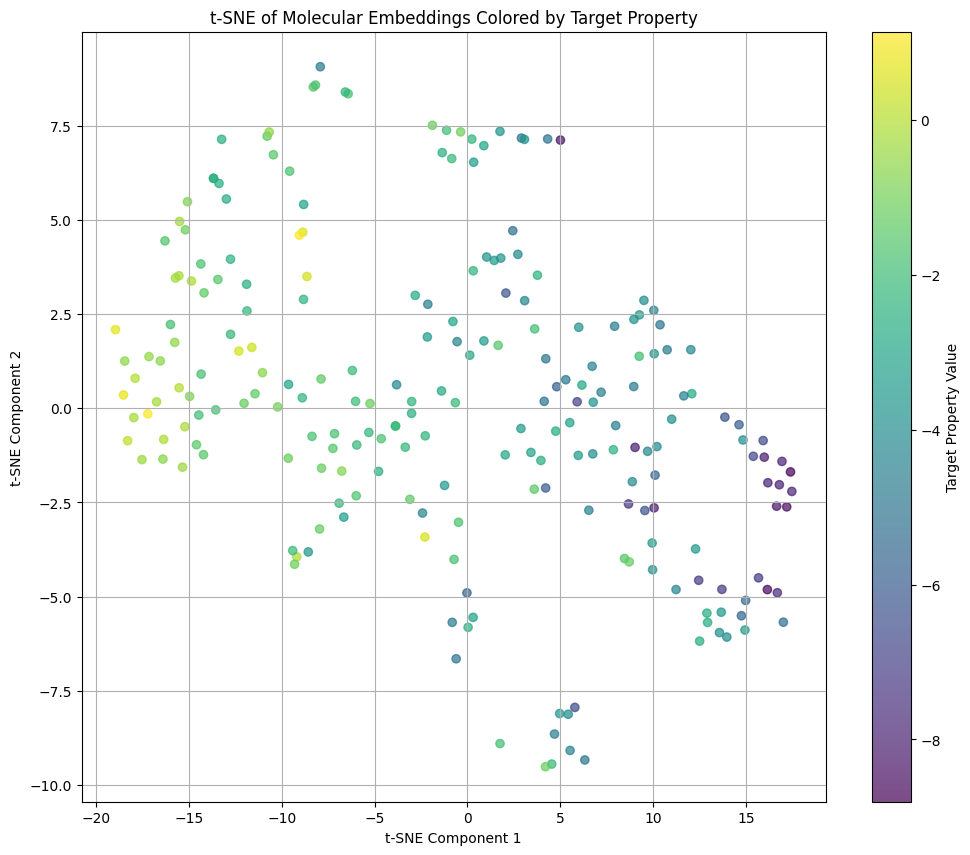

In [23]:
# @title t-SNE
# Apply t-SNE for non-linear dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
embeddings_tsne = tsne.fit_transform(embeddings)

# Visualize with t-SNE
plt.figure(figsize=(12, 10))
scatter = plt.scatter(
    embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=targets, cmap="viridis", alpha=0.7
)
plt.colorbar(scatter, label="Target Property Value")
plt.title("t-SNE of Molecular Embeddings Colored by Target Property")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.grid(True)
plt.show()

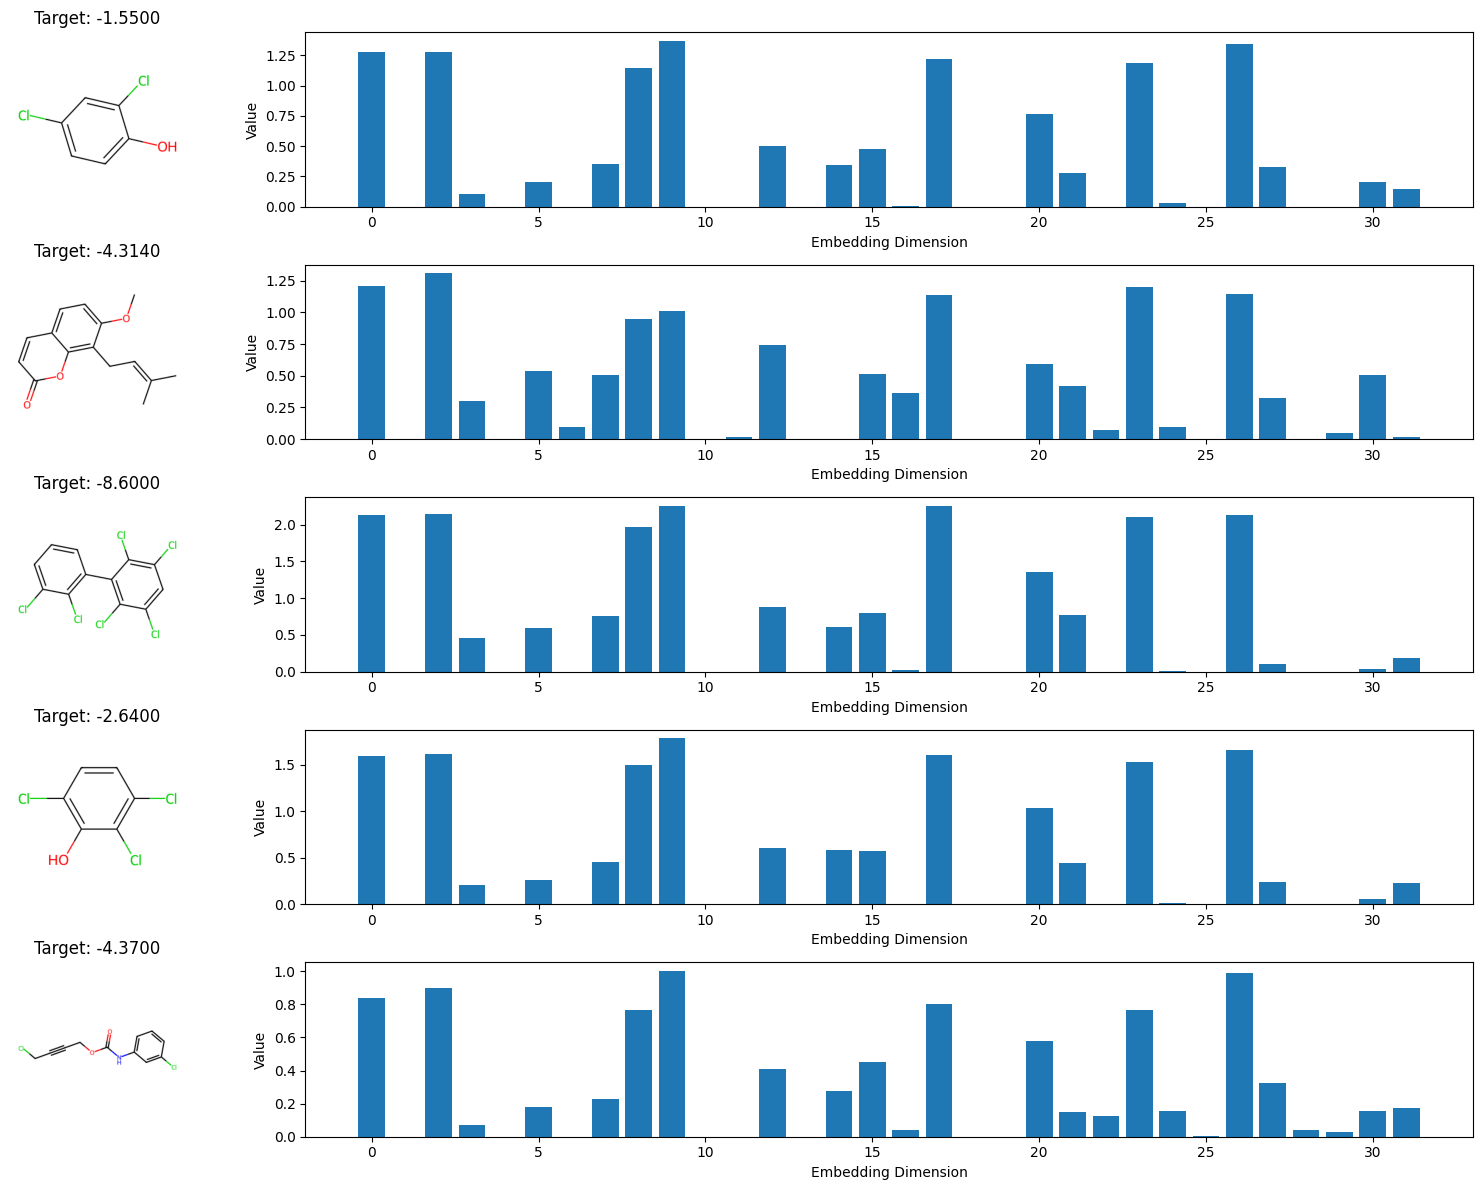

In [24]:
# @title Visualize specific examples
# Choose representative molecules
selected_indices = np.random.choice(
    len(embeddings), 5, replace=False
)  # Randomly select 5 molecules
selected_embeddings = embeddings[
    selected_indices
]  # Select embeddings for the chosen molecules
selected_targets = targets[selected_indices]  # Select targets for the chosen molecules
selected_molecules = [
    molecules[i] for i in selected_indices
]  # Select SMILES for the chosen molecules

# Convert SMILES to RDKit molecules
mol_objects = [Chem.MolFromSmiles(smiles) for smiles in selected_molecules]

# Create a figure with gridspec for custom layout
plt.figure(figsize=(16, 12))
gs = gridspec.GridSpec(len(selected_embeddings), 2, width_ratios=[1, 3])

for i, (embedding, mol, target) in enumerate(
    zip(selected_embeddings, mol_objects, selected_targets)
):
    # Create molecule image in the first column
    ax_mol = plt.subplot(gs[i, 0])
    img = Draw.MolToImage(mol, size=(300, 300))
    ax_mol.imshow(img)
    ax_mol.set_title(f"Target: {target:.4f}")
    ax_mol.axis("off")

    # Create embedding barplot in the second column
    ax_plot = plt.subplot(gs[i, 1])
    ax_plot.bar(range(len(embedding)), embedding)
    ax_plot.set_xlabel("Embedding Dimension")
    ax_plot.set_ylabel("Value")

plt.tight_layout()
plt.show()

## 7. Conclusion

### Key Takeaways

1. **Graph Convolutional Networks** provide a powerful framework for molecular property prediction by directly operating on the molecular graph structure.

2. **Message Passing Mechanism** in GCNs effectively captures both local chemical environments and global molecular properties.

3. **Node Features** represent atom properties, while edges represent bonds, making GNNs a natural fit for molecular representation.

4. **Architecture Variations** such as attention mechanisms and edge feature incorporation can further improve predictive performance.

5. **Real-world Applications** like molecular solubility prediction demonstrate the practical utility of GCNs in drug discovery and materials science.